In [1]:
import os
import PIL
import matplotlib as mpl
import statsmodels.formula.api as smf
import mectools.data as dt

In [2]:
plt = plotter(backend='Agg')
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# args
seed = 2384923
samp = 0.01
BATCH_SIZE = 32
size = 1024
imsize = 256

In [5]:
# spatial scale
pixel = 15 # m/pixel
impixel = pixel*(size/imsize)
print(impixel)

60.0


In [6]:
def load_path(tag, base='../tiles/density', ext='jpg'):
    tag = f'{tag:07d}'
    sub = tag[:4]
    return f'{base}/{size}px/{sub}/{tag}.{ext}'

In [7]:
# evaluation
def eval_model(y, yhat, ymin=-np.inf, ymax=np.inf, nbins=10):
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))

    res = pd.DataFrame({'y': y, 'yhat': yhat}).astype(np.float)
    res['err'] = res['yhat'] - res['y']
    res1 = res.query(f'y > {ymin} and y < {ymax} and yhat > {ymin} and yhat < {ymax}')
    ax0.hexbin(res1['y'], res1['yhat'], cmap=mpl.cm.Blues, gridsize=20);
    
    bins = np.linspace(ymin, ymax, nbins)
    res['ybin'] = np.digitize(res['y'], bins)
    res['ybin'] = np.minimum(nbins-1, res['ybin'])
    bmean = res.groupby('ybin')['yhat'].mean()
    bmean.plot(ax=ax1);

In [8]:
# load in firm and location data
firms = pd.read_csv('../firms/census_2004_geocode.csv', usecols=['id', 'industry', 'income', 'total_assets', 'employees'])
targ = pd.read_csv('../targets/census_firms_2004.csv', usecols=['id', 'lat_wgs84', 'lon_wgs84'])
firms = pd.merge(firms, targ, on='id', how='left').dropna()

# resolve image paths
firms['file'] = firms['id'].apply(load_path)
firms['fexist'] = firms['file'].apply(os.path.exists)
firms = firms[firms['fexist']].drop('fexist', axis=1)

# calculate outcome stats
firms['prod'] = firms['income']/firms['employees']
firms['lprod'] = dt.log(firms['prod'])
firms = firms.dropna(subset=['lprod'])

# calculate residual performance
reg_ind = smf.ols('lprod ~ 0 + C(industry)', data=firms).fit()
firms['lprod_resid'] = reg_ind.resid

In [9]:
density = np.stack([np.array(PIL.Image.open(fn)) for fn in firms['file']])

In [11]:
imgrid = np.arange(imsize)
grid_x, grid_y = np.meshgrid(imgrid, imgrid)
zero_x, zero_y = imsize // 2, imsize // 2
zdist = np.sqrt((grid_x-zero_x)**2+(grid_y-zero_y)**2)
def radial_density(dense, rad0, rad1):
    mask = (zdist >= rad0) & (zdist <= rad1)
    return (mask[None,:,:]*density).mean(axis=(1, 2))
for rad0, rad1 in ((0, 32), (32, 64), (64, 128)):
    firms[f'dense_{rad0}_{rad1}'] = radial_density(density, rad0, rad1)

In [12]:
reg_radial = smf.ols('lprod_resid ~ 1 + dense_0_32 + dense_32_64 + dense_64_128', data=firms).fit()
reg_radial.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            lprod_resid   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     7.963
Date:                Thu, 06 Jun 2019   Prob (F-statistic):           3.02e-05
Time:                        00:46:53   Log-Likelihood:                -1312.2
No. Observations:                 947   AIC:                             2632.
Df Residuals:                     943   BIC:                             2652.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1639      0.055     -2.999      0.003      -0.271      -0.057
dense_0_32      -0.0814      0.841     -0.097      0.923      -1.731       1.568
dense_32_64     -0.5526      0.439     -1.259      0.208      -1.414       0.309
dense_64_128     0.5940      0.127      4.684      0.000       0.345       0.843
==============================================================================
Omnibus:                       54.146   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.131
Skew:                          -0.307   Prob(JB):                     3.35e-29
Kurtosis:                       4.717   Cond. No.                         34.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

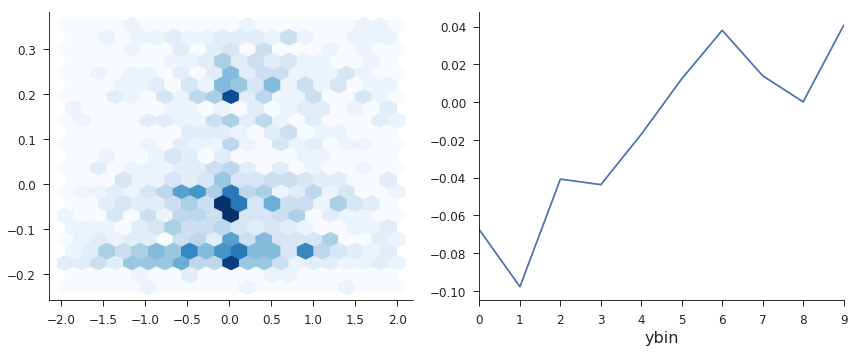

In [13]:
yhat_radial = reg_radial.predict()
eval_model(firms['lprod_resid'].values, yhat_radial, ymin=-2, ymax=2)